In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.optimizers import SGD, Adam
############
import h5py

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\pretrain


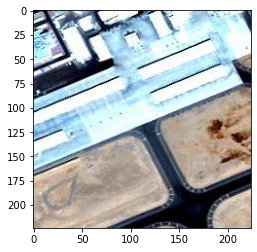

In [3]:
#trainDB = currentPath + os.sep + "train200"
trainDB = currentPath + os.sep + "val200"
valDB = currentPath + os.sep + "val200"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeights = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"
#DenseNetWeights = "/content/gdrive/My Drive/Colab Notebooks/fMoW/model/DenseNet-161_acc-best.h5"
model_name = "DenseNet-161"

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_11_0_msrgb.jpg")
imgplot = plt.imshow(img)

In [4]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [5]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [6]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [7]:

f = h5py.File(DenseNetWeights, 'r')
print(list(f.keys()))
#print("####################################################")
#print(list(f.items()))
groupConv1 = f.get("conv2d_1")
print("####################################################")
print(list(groupConv1.keys()))
print(list(groupConv1.items()))
gc1_2 = groupConv1.get("conv2d_1")
print(list(gc1_2.keys()))
print(list(gc1_2.items()))
print(gc1_2['kernel:0'][0])


['activation_1', 'activation_10', 'activation_100', 'activation_101', 'activation_102', 'activation_103', 'activation_104', 'activation_105', 'activation_106', 'activation_107', 'activation_108', 'activation_109', 'activation_11', 'activation_110', 'activation_111', 'activation_112', 'activation_113', 'activation_114', 'activation_115', 'activation_116', 'activation_117', 'activation_118', 'activation_119', 'activation_12', 'activation_120', 'activation_121', 'activation_122', 'activation_123', 'activation_124', 'activation_125', 'activation_126', 'activation_127', 'activation_128', 'activation_129', 'activation_13', 'activation_130', 'activation_131', 'activation_132', 'activation_133', 'activation_134', 'activation_135', 'activation_136', 'activation_137', 'activation_138', 'activation_139', 'activation_14', 'activation_140', 'activation_141', 'activation_142', 'activation_143', 'activation_144', 'activation_145', 'activation_146', 'activation_147', 'activation_148', 'activation_149'

In [8]:
k = 48
theta = 0.5
repetitions = [6, 12, 36, 24]

input = Input(shape=(224,224,3))

x = Conv2D(2*k, 7, strides=2, padding="same", name="conv2d_1", use_bias=False)(input)
x = MaxPool2D(3, strides=2, padding="same")(x)

for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)

model = Model(input, d)
model.summary()


############
model.save_weights("weightstest.h5")

f = h5py.File("weightstest.h5", 'r')
#print(list(f.keys()))
#print("####################################################")
#print(list(f.items()))
groupConv1 = f.get("conv2d_1")
print("####################################################")
print(list(groupConv1.keys()))
print(list(groupConv1.items()))
gc1_2 = groupConv1.get("conv2d_1")
print(list(gc1_2.keys()))
print(list(gc1_2.items()))
print(gc1_2['kernel:0'][0])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 96)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 56, 56, 96)   384         max_pooling2d[0][0]              
______________________________________________________________________________________________

Total params: 26,682,720
Trainable params: 26,467,392
Non-trainable params: 215,328
__________________________________________________________________________________________________
####################################################
['conv2d_1']
[('conv2d_1', <HDF5 group "/conv2d_1/conv2d_1" (1 members)>)]
['kernel:0']
[('kernel:0', <HDF5 dataset "kernel:0": shape (7, 7, 3, 96), type "<f4">)]
[[[ 2.66924649e-02 -2.01165676e-05 -3.33324522e-02 ...  1.25642419e-02
   -3.96216288e-03 -2.12432016e-02]
  [ 2.32760049e-02 -1.11308526e-02 -1.66373197e-02 ...  9.60612670e-03
   -1.44928861e-02  3.45039144e-02]
  [ 1.79007053e-02  3.44451070e-02 -1.90080702e-02 ...  2.33664885e-02
    2.00005099e-02  2.08358616e-02]]

 [[ 1.13579407e-02 -2.23676730e-02  1.23332366e-02 ... -1.48792230e-02
   -2.78363153e-02  3.26276273e-02]
  [-5.51144034e-03 -2.99258344e-02 -3.26909609e-02 ... -1.36225875e-02
   -3.41067836e-02  1.34528838e-02]
  [-3.10461130e-02  9.86579806e-03 -3.14661153e-02 ...  8.432567

In [9]:
model.load_weights(DenseNetWeights, by_name=True)

model.save_weights("weightstest1.h5")

f = h5py.File("weightstest1.h5", 'r')
#print(list(f.keys()))
#print("####################################################")
#print(list(f.items()))
groupConv1 = f.get("conv2d_1")
print("####################################################")
print(list(groupConv1.keys()))
print(list(groupConv1.items()))
gc1_2 = groupConv1.get("conv2d_1")
print(list(gc1_2.keys()))
print(list(gc1_2.items()))
print(gc1_2['kernel:0'][0])

####################################################
['conv2d_1']
[('conv2d_1', <HDF5 group "/conv2d_1/conv2d_1" (1 members)>)]
['kernel:0']
[('kernel:0', <HDF5 dataset "kernel:0": shape (7, 7, 3, 96), type "<f4">)]
[[[-3.81832719e-02 -3.03403242e-03 -4.02502777e-16 ...  4.83117142e-15
   -2.57492103e-02 -4.33088988e-02]
  [-1.47738993e-01  2.69231386e-03 -1.42138153e-15 ... -4.09241470e-15
   -1.76028553e-02 -3.00941453e-03]
  [-8.54243711e-02  4.42872616e-03 -1.20242425e-15 ... -3.57319028e-15
   -7.19781518e-02  4.94522974e-02]]

 [[-9.87255052e-02 -3.45554203e-02  6.01229756e-16 ...  2.91445042e-15
   -1.94176789e-02 -9.01585445e-02]
  [-2.37829566e-01 -3.07620317e-02 -1.51652811e-15 ... -4.94599902e-15
    4.72110435e-02 -1.28411129e-02]
  [-1.77901715e-01 -3.46089862e-02 -1.77605657e-15 ... -5.99223082e-15
   -5.99883264e-03  9.44705084e-02]]

 [[-1.42916486e-01 -1.51861524e-02  2.11435623e-16 ...  1.07869361e-16
    1.06763868e-02 -1.04883417e-01]
  [-2.90802866e-01 -3.99543419e

In [10]:
f = h5py.File("weightstest.h5", 'r')
#print(list(f.keys()))
#print("####################################################")
#print(list(f.items()))
groupConv1 = f.get("conv2d_1")
print("####################################################")
print(list(groupConv1.keys()))
print(list(groupConv1.items()))
gc1_2 = groupConv1.get("conv2d_1_2")
#print(list(gc1_2.keys()))
#print(list(gc1_2.items()))

####################################################
['conv2d_1']
[('conv2d_1', <HDF5 group "/conv2d_1/conv2d_1" (1 members)>)]


In [11]:
x = GlobalAvgPool2D()(d)
output = Dense(62, activation="softmax")(x)


model = Model(input, output)

NameError: name 'num_categories' is not defined

In [ ]:
model.summary()
#plot_model(model, show_shapes=True)